# **Notebook 2: Hospital Length of Stay (LOS) Prediction**

## **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Read the healthcare dataset file
data = pd.read_csv("healthcare_data.csv")

In [5]:
# Copying data to another variable to avoid any changes to original data
same_data = data.copy()

## **Data Preparation for Model Building**

In [78]:
# Creating dummy variables for the categorical columns
# drop_first=True is used to avoid redundant variables
data = pd.get_dummies(
    data,
    columns = data.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)

In [80]:
# Check the data after handling categorical data
data

,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,Admission_Deposit,Stay (in days),Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,Ward_Facility_Code_B,Ward_Facility_Code_C,Ward_Facility_Code_D,Ward_Facility_Code_E,Ward_Facility_Code_F,doctor_name_Dr John,doctor_name_Dr Mark,doctor_name_Dr Nathan,doctor_name_Dr Olivia,doctor_name_Dr Sam,doctor_name_Dr Sarah,doctor_name_Dr Simon,doctor_name_Dr Sophia,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100,gender_Male,gender_Other,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_Other,Insurance_Yes
0,4,0,4,2966.408696,8,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
1,4,2,2,3554.835677,9,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False
2,2,8,2,5624.733654,7,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
3,4,7,4,4814.149231,8,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False
4,2,10,2,5169.269637,34,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,4,2,3,4105.795901,10,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False
499996,13,8,2,4631.550257,11,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
499997,2,3,2,5456.930075,8,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
499998,2,1,2,4694.127772,23,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False


In [82]:
# Separating independent variables and the target variable
x = data.drop('Stay (in days)',axis=1)

y = data['Stay (in days)'] 

In [84]:
# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

In [86]:
# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (400000, 41)
Shape of test set :  (100000, 41)


## **Model Building**

In [89]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

### Linear Regression

In [92]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(x_train, y_train)

LinearRegression()

In [94]:
# Checking performance on the training data
linear_reg = model_performance_regression(model, x_train, y_train)
linear_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


In [96]:
# Checking performance on the testing data
linear_reg_test = model_performance_regression(model, x_test, y_test)
linear_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842964,19.676966


**Observations:**

- **The Root Mean Squared Error** and the **adjusted $R^2$** of train and test data are **very close**, indicating that the **model is not overfitting** to the training data.
- The adjusted $R^2$ of ~0.84 implies that the independent variables are able to explain ~84% variance in the target variable.
- Mean Absolute Error (MAE) indicates that the current model can predict LOS of patients within **mean error of 2.15 days** on the test data.
- The units of both RMSE and MAE are the same. But RMSE is greater than MAE because it penalizes the outliers more.
- **Mean Absolute Percentage Error is ~19%** on the test data, indicating that the average difference between the predicted value and the actual value is ~19%.

## Regularization

---

## Regularization in Machine Learning

**Regularization** is a method of preventing the model from **overfitting** by adding additional information to it.

The machine learning model may perform well with training data but not with test data. This means that when dealing with unseen data, the model cannot anticipate the result since it introduces noise into the output, and so the model is termed **overfit**. A **regularization** technique is used to solve this problem. By lowering the magnitude of the variables, this technique allows for the preservation of all variables or features in the model. As a result, it maintains accuracy as well as model generalization. Its primary function is to regularize or lower the coefficient of features towards zero. In other words, "the regularization strategy reduces the magnitude of the features while maintaining the same number of features." Regularization is accomplished by introducing a penalty or complexity term into the complex model.

---
**Regularization procedures are classified into two types, which are listed below:**

---
- **Ridge Regression**:
  - Ridge regression is a type of linear regression in which a **small amount of bias** is introduced to improve long-term predictions.
  - Ridge regression is a regularization technique that is **used to reduce model complexity**. It's also known as **$L_2$ regularization**.
  - The penalty term is added to the cost function in this technique. The amount of bias introduced into the model is referred to as the **Ridge Regression penalty**.
  - It can be computed by multiplying the squared weight of each individual feature by the alpha.
  - A general linear or polynomial regression will fail if the independent variables are highly collinear; Ridge regression can be utilized to tackle such situations.
  - When there are more parameters than samples, it is easier to solve problems using Ridge Regression.
---
- **Lasso Regression**:
  - **Lasso regression** is another regularization technique for reducing model complexity. It is an abbreviation for **Least Absolute and Selection Operator**.
  - It is identical to Ridge Regression except that the **penalty term only contains absolute weights** rather than a square of weights.
  - Because it uses absolute data, it **can decrease the slope to zero**, whereas **Ridge Regression can only get close to zero**.
  - It is also known as **$L_1$ regularization**.

---

## Ridge Regression

### Ridge Regression with default parameters

In [144]:
ridge_model = Ridge() #creating Ridge Regression model
ridge_model.fit(x_train, y_train) # Fitting the data into the model

Ridge()

In [146]:
ridge_reg = model_performance_regression(ridge_model, x_test, y_test) #getting performance metrics on test data
ridge_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144057,2.155826,0.843028,0.842963,19.677968


**Observations:**

- The performance metrics are showing almost similar results as compared to the Least Squares method.

### Ridge Regression with optimized $\large\alpha$

In [150]:
folds = KFold(n_splits=10, shuffle=True, random_state=1) 
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]} 
model = Ridge()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [152]:
model_cv.best_params_ #getting optimised parameters for alpha

{'alpha': 0.1}

In [154]:
ridge_model_tuned = Ridge(alpha=0.1) ##creating Tuned Ridge Regression model using optimised alpha value
ridge_model_tuned.fit(x_train, y_train) # Fitting the data into the tuned model

Ridge(alpha=0.1)

In [156]:
ridge_reg_tuned = model_performance_regression(ridge_model_tuned, x_test, y_test) #getting performance metrics on test data
ridge_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155771,0.843028,0.842964,19.677066


**Observations:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.1.
- It can be observed that after tuning the parameters of Ridge Regression, the performance parameters does not change implying that Ridge Regression does not help in improving the model.

## Lasso Regression

### Lasso Regression with default parameters

In [158]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso()

In [160]:
lasso_reg = model_performance_regression(lasso_model, x_test, y_test)
lasso_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.064339,3.873332,0.416006,0.415766,34.652716


**Observations:**

- After fitting the data into Lasso Regression Model with default value of alpha (=1), the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune the alpha to get the optimized value similar to Ridge Regression using Grid SearchCV.

### Lasso Regression with optimized $\large\alpha$

In [163]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [165]:
model_cv.best_params_

{'alpha': 0.001}

In [167]:
lasso_model_tuned = Lasso(alpha=0.001)
lasso_model_tuned.fit(x_train, y_train)

Lasso(alpha=0.001)

In [169]:
lasso_reg_tuned = model_performance_regression(lasso_model_tuned, x_test, y_test)
lasso_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144315,2.157198,0.843002,0.842938,19.702959


**Observation:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001.
- The performance metrics are showing similar results as compared to Least Squares method and Ridge Regression, implying that after adding the penalty, the model does not improve. 

## Elastic Net Regression

**Elastic Net** is a regularized regression model that combines $L_1$ and $L_2$ penalties, i.e., **lasso** and **ridge** regression. As a result, it performs a more efficient smoothing process.

- The elastic net includes the **penalty of lasso regression**, and **when used in isolation, it becomes the ridge regression**. 
- In the procedure of regularization with an elastic net, **first, the coefficient of ridge regression is determined**. 
- After this, a **lasso algorithm is performed on the ridge regression coefficient to shrink the coefficient**.
- It has two parameters to be set, $\large\alpha_1$ and $\large\alpha_2$ where $\large\alpha_1$ controls the $L_1$ penalty and $\large\alpha_2$ controls the $L_2$ penalty.

### Elastic Net Regression with default parameters

In [173]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(x_train, y_train)

ElasticNet()

In [175]:
elasticnet_reg = model_performance_regression(elasticnet_model, x_test, y_test)
elasticnet_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.556087,4.678504,0.317455,0.317175,40.121657


**Observations:**

- After fitting the data into Elastic Net Model with default value of alpha (=1) and L1_ratio, the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune the alpha to get the optimized value similar to Ridge Regression using Grid SearchCV.

### Elastic Net Regression with optimized $\alpha$ and $L_1-ratio$

In [178]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]}
model = ElasticNet()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]},
             return_train_score=True, scoring='r2')

In [181]:
model_cv.best_params_

{'alpha': 0.001, 'l1_ratio': 0.05}

In [180]:
elasticnet_model_tuned = ElasticNet(alpha=0.001, l1_ratio=0.05)
elasticnet_model_tuned.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.05)

In [184]:
elasticnet_reg_tuned = model_performance_regression(elasticnet_model_tuned, x_test, y_test)
elasticnet_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.157478,2.178911,0.841685,0.84162,19.981572


**Observation**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001, and l1_ratio = 0.05.
- The performance metrics are showing almost similar results as compared to Least Squares method, Ridge Regression and Lasso Regression, implying that after tuning the Elastic Net, the model does not improve.

In [186]:
models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,3.144055,2.155765,0.843028,0.842964,19.676966
0,Ridge Regression,3.144057,2.155826,0.843028,0.842963,19.677968
0,Ridge Regression Tuned,3.144055,2.155771,0.843028,0.842964,19.677066
0,Lasso Regression,6.064339,3.873332,0.416006,0.415766,34.652716
0,Lasso Regression Tuned,3.144315,2.157198,0.843002,0.842938,19.702959
0,Elastic Net Regression,6.556087,4.678504,0.317455,0.317175,40.121657
0,Elastic Net Regression Tuned,3.157478,2.178911,0.841685,0.841620,19.981572


**Observations:**

- As per the above result, the **Least Squares Method** is giving the best results as compared to other models. 
- Regularization technique does not offer any significant improvement to the performance metrics.
- So, some **Non Linear models** will be applied to check if the model performance improves or not.

### Forward Feature Selection using SequentialFeatureSelector

**SequentialFeatureSelector** will be used to select a subset of key features using forward feature selection. It is a greedy search algorithm that is used to **reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d**. It is useful to automatically select a subset of the most relevant featuresthat are most relevant to the problem.

**Feature selection importantance**

- Reduces dimensionality
- Discards deceptive features
- Speeds training/testing

Forward feature selection starts with an empty model and adds variables one by one.
In each forward step, one variable is added that gives the highest improvement to the model.
Forward feature selection will be used on all the variables.

In [191]:
# Installing mlxtend library. You need to run the below code only once if mlxtend library is not previously installed.

!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 393.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.4 MB 819.2 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.4 MB 1.3 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.4 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.4 MB 2.5 MB/s eta 0:00:01
   -------------------------------- ------- 1.1/1.4 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 3.7 MB/s eta 0:00:00


In [193]:
# Importing Sequential Feature Selector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

**Parameters to pass in SequentialFeatureSelector:**

- **estimator:** scikit-learn classifier or regressor.

- **k_features:** int or tuple or str (default: 1). 

    - The number of features to choose, where k features equals the entire feature collection, can be specified as an integer.
    - The SFS will consider returning any feature combination between min and max that scored highest in cross-validation if a tuple containing a min and max value is provided. For example, instead of a set amount of characteristics k, the tuple (1, 4) will return any combination of 1 to 4 features.
    - A string argument such as "best" or "parsimonious". If you choose "best," the feature selector will provide the feature subset with the best cross-validation performance. If the input "parsimonious" is provided, the smallest feature subset that is within one standard error of the cross-validation performance will be chosen.
    
- **forward:** bool (default: True). Forward selection if True, backward selection otherwise.

- **floating:** bool (default: False). Adds a conditional exclusion/inclusion if True:

    - Sequential floating forward selection (SFFS) starts from the empty set.
    - After	each forward step, it performs backward	steps as long as the objective function increases.
    - Once it stops increasing, the forward selection is continued.

- **verbose:** int (default: 0), level of verbosity to use in logging. If 0 then no output, if 1then the number of features in the current set, and if 2 then detailed logging including timestamp and cv scores at each step.

- **scoring:** str, callable, or None (default: None). If None (default), uses 'accuracy' for sklearn classifiers and 'r2' for sklearn regressors.

- **cv:** int (default: 5). Integer or iterable yielding train, test splits. If cv is an integer and estimator is a classifier (or y consists of integer class labels) stratified k-fold. Otherwise, regular k-fold cross-validation is performed. No cross-validation if cv is None, False, or 0.

- **n_jobs:** int (default: 1). The number of CPUs to use for evaluating different feature subsets in parallel. -1 means 'all CPUs'.

In [196]:
# Initializing the model to pass to SFS
reg = LinearRegression()

# Forward Feature Selection
sfs = SFS(
    reg,
    k_features=x_train.shape[1],
    forward=True, 
    floating=False,
    scoring="r2",
    n_jobs=-1,  
    verbose=2,
    cv=5,
)

# Perform SFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   28.6s finished

[2025-09-19 10:49:25] Features: 1/41 -- score: 0.49188988610314566[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.7s finished

[2025-09-19 10:49:54] Features: 2/41 -- score: 0.6046160397618389[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   28.4s finished

[2025-09-19 10:50:23] Features: 3/41 -- score: 0.6461909142668083[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   29.0s finished

[2025-09-19 10:50:52] Features: 4/41 -- score: 0.701305491423807[Parallel(n_jobs=-1)]: U

Now, the model performance with addition of each feature wil be plotted by using **plot_sequential_feature_selection** function. It has the following parameters:

- **metric_dict:** is a dictionary with items where each dictionary value is a list with the number of iterations (number of feature subsets) as its length. The **dictionary keys** corresponding to these lists are as follows:
    - 'feature_idx': tuple of the indices of the feature subset 
    - 'cv_scores': list with individual CV scores 
    - 'avg_score': of CV average scores
    - 'feature_names': Name of features in the subset
    - 'ci_bound': confidence interval bound of the CV score average
    - 'std_dev': standard deviation of the CV score average 
    - 'std_err': standard error of the CV score average 

- **figsize:** tuple (default: None). Height and width of the figure.

- **kind:** str (default: "std_dev"). The kind of error bar or confidence interval in {'std_dev', 'std_err', 'ci', None}.

- **color:** str (default: "blue"). Color of the lineplot (accepts any matplotlib color name).

- **bcolor:** str (default: "steelblue"). Color of the error bars / confidence intervals (accepts any matplotlib color name).

- **marker:** str (default: "o"). Marker of the line plot (accepts any matplotlib marker name).

- **alpha:** float in [0, 1] (default: 0.2). Transparency of the error bars / confidence intervals.

- **ylabel:** str (default: "Performance"). Y-axis label.

- **confidence_interval:** float (default: 0.95). Confidence level if kind='ci'.

In [218]:
metrics = sfs.get_metric_dict()

# Extract and organize data into a list of dictionaries
data = []
for k, v in metrics.items():
    row = {
        'Feature Count': k,
        'Feature Index': v['feature_idx'],
        'Feature Names': v['feature_names'],
        'CV Scores': v['cv_scores'],
        'CI Bound': v['ci_bound'],
        'Std Dev': v['std_dev']
    }
    data.append(row)

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

    Feature Count                                      Feature Index  \
0               1                                               (5,)   
1               2                                             (5, 6)   
2               3                                         (5, 6, 23)   
3               4                                     (5, 6, 23, 24)   
4               5                                 (5, 6, 22, 23, 24)   
5               6                             (5, 6, 21, 22, 23, 24)   
6               7                          (4, 5, 6, 21, 22, 23, 24)   
7               8                       (4, 5, 6, 7, 21, 22, 23, 24)   
8               9                   (4, 5, 6, 7, 18, 21, 22, 23, 24)   
9              10               (4, 5, 6, 7, 18, 21, 22, 23, 24, 37)   
10             11            (0, 4, 5, 6, 7, 18, 21, 22, 23, 24, 37)   
11             12        (0, 4, 5, 6, 7, 12, 18, 21, 22, 23, 24, 37)   
12             13    (0, 4, 5, 6, 7, 12, 18, 21, 22, 23, 24, 32,

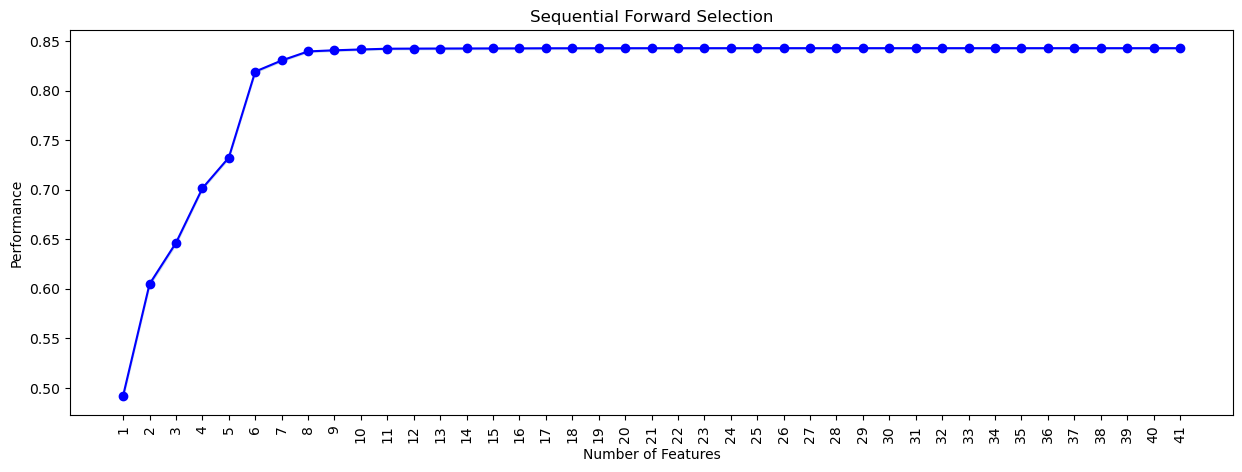

In [220]:
# To plot the performance of the model with addition of each feature
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=(15, 5))
plt.title("Sequential Forward Selection")
plt.xticks(rotation=90)
plt.show()

**Observations:** 

- It can be observed that the performance increases till the 8th feature and then becomes constant.
- The decision to choose the *k_features* depends on the $R^2$ vs the complexity of the model.
    - With 8 features, an $R^2$ of 0.840 is achieved.
    - With 20 features, an $R^2$ of 0.844 is achieved.
    - With 42 features, an $R^2$ of 0.843 is achieved.With 8 features, getting an $R^2$ of 0.840.
- The increase in $R^2$ is not very significant, as approximately the same values are obtained with a less complex model.
- Therefore, only 8 features will be used to build the Linear Regression model, but you can experiment by selecting a different number.
- The number of features chosen can also depend on the business context and use case of the model.


## Running the Sequential Feature Selector again to find the best 8 features for the model

In [222]:
reg = LinearRegression()

# Forward feature selection with 8 features
sfs = SFS(
    reg,
    k_features=8,
    forward=True,
    floating=False,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    cv=5,
)

# Perform SFFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   31.8s finished

[2025-09-19 11:27:22] Features: 1/8 -- score: 0.49188988610314566[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.0s finished

[2025-09-19 11:27:50] Features: 2/8 -- score: 0.6046160397618389[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   28.8s finished

[2025-09-19 11:28:19] Features: 3/8 -- score: 0.6461909142668083[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   32.0s finished

[2025-09-19 11:28:51] Features: 4/8 -- score: 0.701305491423807[Parallel(n_jobs=-1)]: Using

In [224]:
# Selecting the features which are important for the model
feat_cols = list(sfs.k_feature_idx_)
print(feat_cols)

[4, 5, 6, 7, 21, 22, 23, 24]


In [226]:
# Checking the names of the important features
x_train.columns[feat_cols]

Index(['Department_anesthesia', 'Department_gynecology',
       'Department_radiotherapy', 'Department_surgery', 'Age_11-20',
       'Age_21-30', 'Age_31-40', 'Age_41-50'],
      dtype='object')

**Now, we will fit the Linear Regression model using these 8 features only.**

In [228]:
# Creating the new x_train data
x_train_final = x_train[x_train.columns[feat_cols]]

In [230]:
# Creating the new x_test data
x_test_final = x_test[x_train_final.columns]

In [232]:
# Fitting Linear Regression model on the new training data
lin_reg_model2 = LinearRegression()
lin_reg_model2.fit(x_train_final, y_train)

LinearRegression()

In [234]:
# Checking model performance on the training data
lin_reg_model2_train_perf = model_performance_regression(lin_reg_model2, x_train_final, y_train)
lin_reg_model2_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.167762,2.16747,0.83952,0.839516,19.769004


In [236]:
# Checking model performance on the testing data
lin_reg_model2_test_perf = model_performance_regression(lin_reg_model2, x_test_final, y_test)
lin_reg_model2_test_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.175516,2.174951,0.839871,0.839858,19.83425


**Observations:**
- The performance looks approximately the same as the previous model with all the variables.
- Comparing the two models.

In [240]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [linear_reg.T, lin_reg_model2_train_perf.T], axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression sklearn",
    "Linear Regression sklearn (SFS features)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Linear Regression sklearn,Linear Regression sklearn (SFS features)
RMSE,3.135093,3.167762
MAE,2.146244,2.167470
R-squared,0.842813,0.839520
Adj. R-squared,0.842796,0.839516
MAPE,19.591833,19.769004


In [242]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [linear_reg_test.T, lin_reg_model2_test_perf.T], axis=1,
)

models_test_comp_df.columns = [
    "Linear Regression sklearn",
    "Linear Regression sklearn (SFS features)",
]

print("Test performance comparison:")
models_test_comp_df

Test performance comparison:


,Linear Regression sklearn,Linear Regression sklearn (SFS features)
RMSE,3.144055,3.175516
MAE,2.155765,2.174951
R-squared,0.843028,0.839871
Adj. R-squared,0.842964,0.839858
MAPE,19.676966,19.834250


**Observations:**

- The new model (**lin_reg_model2**) uses 8 features in comparison to 42 features for the previous model (**linear_reg**), i.e., the number of features has reduced by ~81%.
- The performance of the new model, however, is very close to the previous model.
- The exploration includes building a Linear Regression model for this problem statement of predicting the likely length of stay of a patient for a hospital visit, and also identifies the most important features for the model, and trained the model using only those features, without compromising the model performance by much.
- However, being a linear model, it is more interpretable than a model with high predictive power. The performance metrics at prediction can be improved with more complex and non-linear models.